In [1]:
import cv2 as cv
from keras.callbacks import ModelCheckpoint
import os

In [2]:
import os
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical

data_path = 'dataset'
categories = os.listdir(data_path)

labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

print(label_dict)
print(categories)
print(labels)

img_size = 100
data = []
target = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            target.append(label_dict[category])

        except Exception as e:
            print('Exception : ', e)

data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

new_target = to_categorical(target)

np.save('data', data)
np.save('target', new_target)

{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [3]:
data = np.load('data.npy')
new_target = np.load('target.npy')

model = Sequential()

model.add(Conv2D(200, (3, 3), input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(100, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(50, activation='relu'))
# Adjust the number of units in the output layer based on your problem
model.add(Dense(len(categories), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, new_target, test_size=0.1)

checkpoint = ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose=0, save_best_only=True, mode='auto')

# Fit the model with the callback
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/5
39/39 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.5121

INFO:tensorflow:Assets written to: model-001.model\assets


INFO:tensorflow:Assets written to: model-001.model\assets


39/39 [==============================] - 23s 578ms/step - loss: 0.7058 - accuracy: 0.5121 - val_loss: 0.6581 - val_accuracy: 0.7246
Epoch 2/5
39/39 [==============================] - ETA: 0s - loss: 0.5794 - accuracy: 0.6430

INFO:tensorflow:Assets written to: model-002.model\assets


INFO:tensorflow:Assets written to: model-002.model\assets


39/39 [==============================] - 23s 596ms/step - loss: 0.5794 - accuracy: 0.6430 - val_loss: 0.5346 - val_accuracy: 0.8043
Epoch 3/5
39/39 [==============================] - ETA: 0s - loss: 0.4688 - accuracy: 0.8376

INFO:tensorflow:Assets written to: model-003.model\assets


INFO:tensorflow:Assets written to: model-003.model\assets


39/39 [==============================] - 22s 561ms/step - loss: 0.4688 - accuracy: 0.8376 - val_loss: 0.3999 - val_accuracy: 0.9420
Epoch 4/5
39/39 [==============================] - ETA: 0s - loss: 0.3941 - accuracy: 0.9208

INFO:tensorflow:Assets written to: model-004.model\assets


INFO:tensorflow:Assets written to: model-004.model\assets


39/39 [==============================] - 22s 561ms/step - loss: 0.3941 - accuracy: 0.9208 - val_loss: 0.3432 - val_accuracy: 0.9710
Epoch 5/5
39/39 [==============================] - ETA: 0s - loss: 0.3559 - accuracy: 0.9507

INFO:tensorflow:Assets written to: model-005.model\assets


INFO:tensorflow:Assets written to: model-005.model\assets


39/39 [==============================] - 21s 541ms/step - loss: 0.3559 - accuracy: 0.9507 - val_loss: 0.3355 - val_accuracy: 0.9203


In [5]:
import matplotlib.pyplot as plt

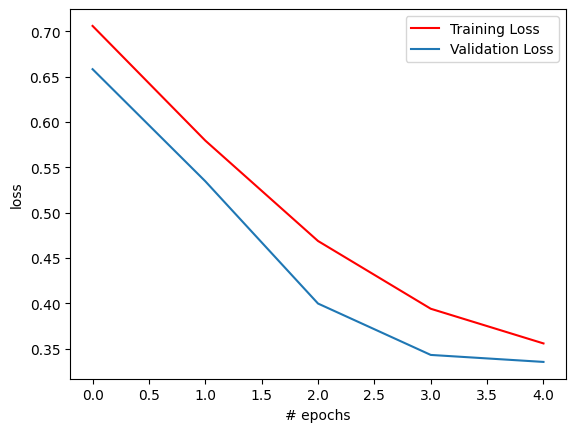

In [6]:
plt.plot(history.history['loss'], 'r', label= 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('# epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [7]:
print(model.evaluate(X_test,y_test))

5/5 [==============================] - 1s 106ms/step - loss: 0.3355 - accuracy: 0.9203
[0.3355270326137543, 0.9202898740768433]


In [2]:
from keras.models import load_model
import cv2 as cv
import numpy as np

In [6]:
model = load_model('model-005.model')

face_clsfr = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

source = cv.VideoCapture(1)

label_dict = {0 : 'MASK', 1 : 'NO MASK'}
color_dict = {0 : (0,255,0), 1 : (0,0,255)}

In [7]:
while True:
    ret, img = source.read()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_clsfr.detectMultiScale(gray, 1.3, 5)

    for x, y, w, h in faces:
        face_img = gray[y:y+h, x:x+w]
        resized = cv.resize(face_img, (100, 100))
        normalized = resized / 255.0
        reshaped = np.reshape(normalized, (1, 100, 100, 1))
        result = model.predict(reshaped)

        label = np.argmax(result, axis=1)[0]

        cv.rectangle(img, (x, y), (x+w, y+h), color_dict[label], 2)
        cv.rectangle(img, (x, y-40), (x+w, y), color_dict[label], -1)
        cv.putText(img, label_dict[label], (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

    cv.imshow('live', img)
    if cv.waitKey(1) == ord('q'):
        break

cv.destroyAllWindows()  # Corrected function name
source.release()

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
